In [1]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32


In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
  "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
    
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names=dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

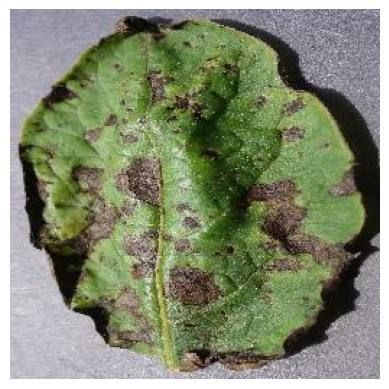

In [7]:
for image_batch in dataset.take(1):
    plt.imshow(image_batch[0][0].numpy().astype("uint8"))
    plt.axis("off")
    plt.show()
  

In [8]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds=dataset.take(54)
len(train_ds)

54

In [10]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size


6.800000000000001

In [12]:
val_ds=test_ds.take(6)
test_ds=test_ds.skip(6)

In [13]:
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [18]:

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),



])
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
EPOCHS=5

history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/5


54/54 [==============================] - 32s 595ms/step - loss: 0.0260 - accuracy: 0.9913 - val_loss: 0.0062 - val_accuracy: 1.0000
Epoch 2/5
54/54 [==============================] - 32s 593ms/step - loss: 0.0291 - accuracy: 0.9919 - val_loss: 0.0146 - val_accuracy: 1.0000
Epoch 3/5
54/54 [==============================] - 31s 579ms/step - loss: 0.0252 - accuracy: 0.9902 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 4/5
54/54 [==============================] - 32s 594ms/step - loss: 0.0162 - accuracy: 0.9954 - val_loss: 0.0218 - val_accuracy: 0.9844
Epoch 5/5
54/54 [==============================] - 32s 594ms/step - loss: 0.0171 - accuracy: 0.9954 - val_loss: 0.0152 - val_accuracy: 0.9948


In [34]:
score=model.evaluate(test_ds)

8/8 [==============================] - 1s 154ms/step - loss: 0.0381 - accuracy: 0.9914


In [35]:
score

[0.03814714401960373, 0.9913793206214905]

In [36]:
history.params


{'verbose': 1, 'epochs': 5, 'steps': 54}

In [37]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
history.history['accuracy']

[0.9913194179534912,
 0.9918981194496155,
 0.9901620149612427,
 0.9953703880310059,
 0.9953703880310059]

first image to predict
first image's actual labes : Potato___Early_blight
1/1 [==============================] - 0s 185ms/step
predicted label : Potato___Early_blight


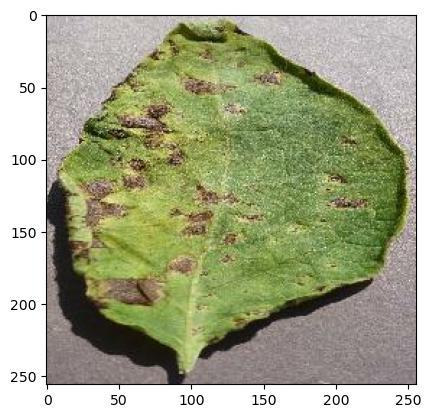

In [66]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
   first_image=(image_batch[0].numpy().astype("uint8"))
   first_label=label_batch[0].numpy()
   print("first image to predict")
   plt.imshow(first_image)
   print("first image's actual labes :",class_names[first_label])
   batch_prediction=model.predict(image_batch)
   print("predicted label :",class_names[np.argmax(batch_prediction[0])])

In [67]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 24ms/step


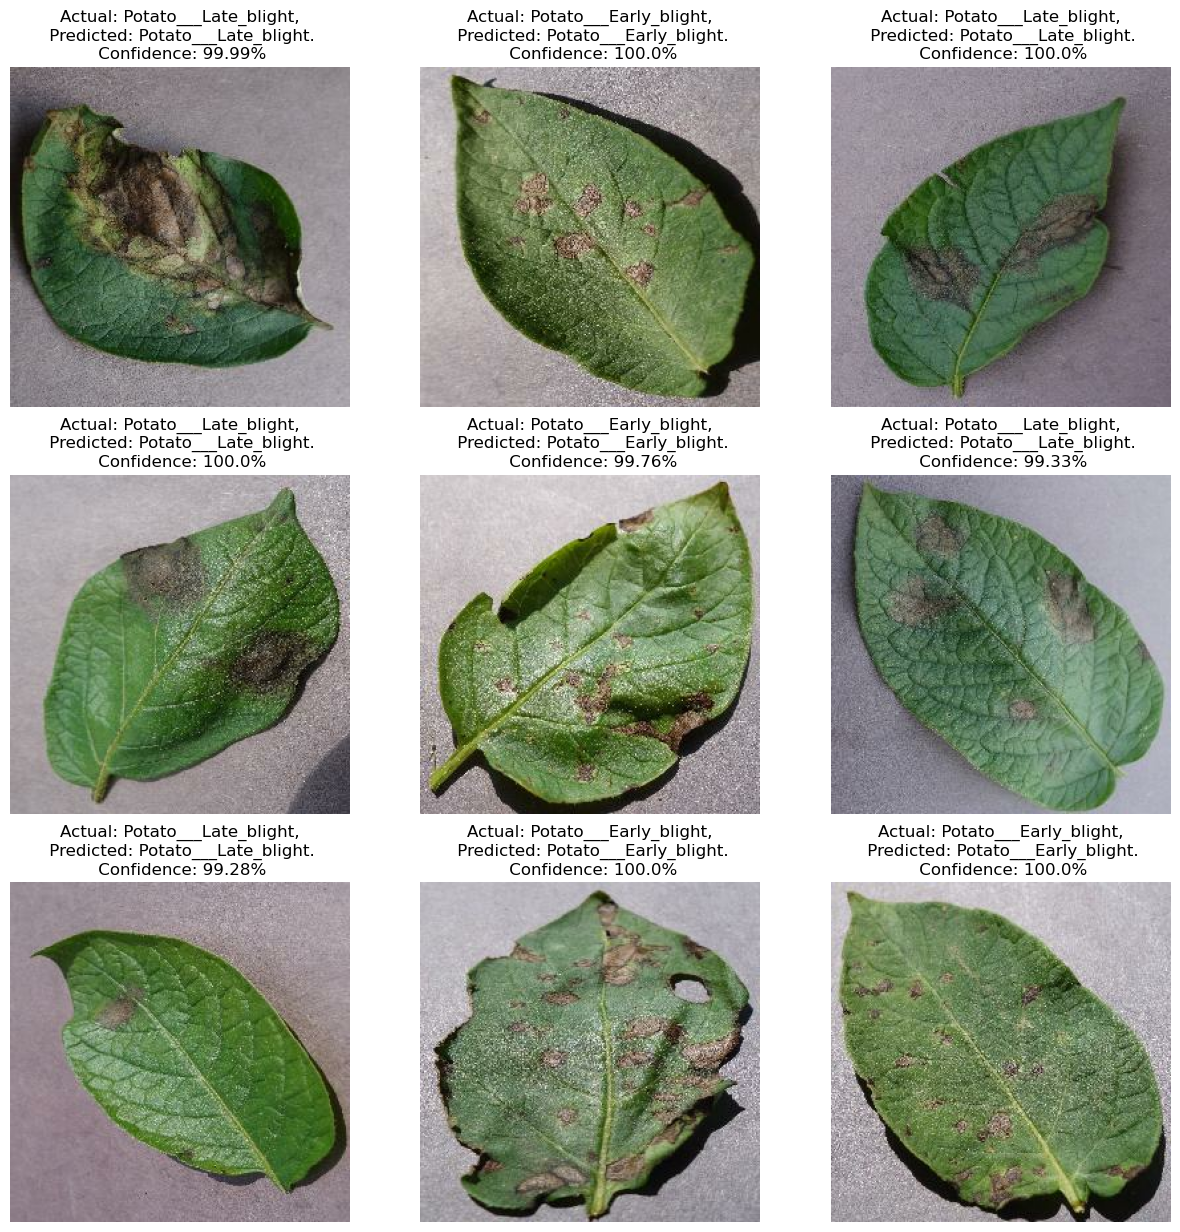

In [68]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [78]:
model_version=2
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets
